# Create Predictions for Kaggle submission

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from xgboost.sklearn import XGBRegressor

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Get transformed training dataset

In [2]:
train = pd.read_csv('./data/features.csv', index_col=0)

### Transform Test Data

Before making predictions on the test data, we need to apply the same transformation steps as the train dataset. Overall, there are three steps
1. Drop continuous variables of 'cont9', 'cont10', 'cont12', 'cont13'
2. Apply One Hot Encoding to the category variables,
3. Slice the feature columns that were picked in the LassCV, RFE, and RFECV steps

In [3]:
test = pd.read_csv('./data/test.csv', index_col=0)
test_df = test.drop(['cont9', 'cont10', 'cont12', 'cont13'], axis=1)

In [4]:
cat_test = test_df.select_dtypes(include=['O'])
con_test = test_df.select_dtypes(include=['float'])

In [5]:
cat_encoded_test = pd.get_dummies(
    cat_test, drop_first=True, prefix=cat_test.columns)
encoded_test = pd.merge(cat_encoded_test, con_test, left_index=True,
                        right_index=True, how='inner')
final_test = encoded_test.loc[:, train.columns[:-1]]

In [6]:
feature = train.drop(['loss'], axis=1)
target = train['loss']

In [7]:
p_trans = PowerTransformer()

train['loss_transform'] = p_trans.fit_transform(train[['loss']])

target_t = train['loss_transform']

#### Base model (no tuning)

In [8]:
def loss_submit(name, reg, X, y, test):
    """Initiate model, transform target, and create dataframe and csv for kaggle submission,
    create distribution plot for the predicted values


    Args:
        name: name to label csv file with predictions
        reg: regressors
        X: train dataset
        y: target dataset
        test: test dataset

    Returns:
        csv file with predictions for kaggle submission
        distplot on the predicted loss
    """
    mod = TransformedTargetRegressor(
        regressor=reg, transformer=PowerTransformer())
    reg = mod.fit(X, y)
    pred = reg.predict(test)
    df = pd.DataFrame({'loss': pred})
    df.index = test.index
    df.to_csv('./data/'+name+'.csv', index=True)
    sns.distplot(pred)
    plt.xlabel('predicted loss')
    plt.title('loss value predictions distribution by {}'.format(name))

##### Dummy and SGDRegression

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


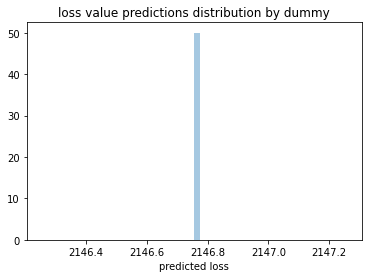

In [9]:
loss_submit('dummy', DummyRegressor(), feature, target, final_test)

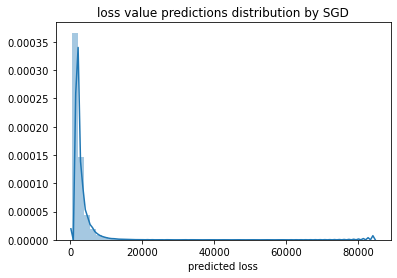

In [10]:
loss_submit('SGD', SGDRegressor(), feature, target, final_test)

##### LightGbm

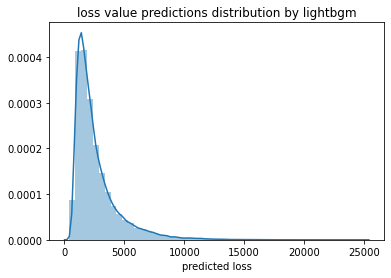

In [11]:
loss_submit('lightbgm', LGBMRegressor(), feature, target, final_test)

##### Xgboost 

[19:23:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


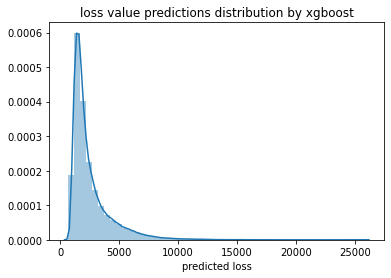

In [12]:
loss_submit('xgboost', XGBRegressor(), feature, target, final_test)

##### Catboost

Given the special properties of the algorithm, both train and test datasets will need a different transformation

In [13]:
le = LabelEncoder()

In [14]:
ori_train = pd.read_csv('./data/train.csv', index_col=0)
cat_train = ori_train.drop(
    ['cont9', 'cont10', 'cont12', 'cont13', 'loss'], axis=1)

In [15]:
cat_train['type'] = 'train'

In [16]:
test_df['type'] = 'test'

In [17]:
consol = cat_train.append(test_df)

In [18]:
consol_code = consol.apply(le.fit_transform)

In [19]:
train_cat_df = consol_code.query('type==1')
test_cat_df = consol_code.query('type==0')

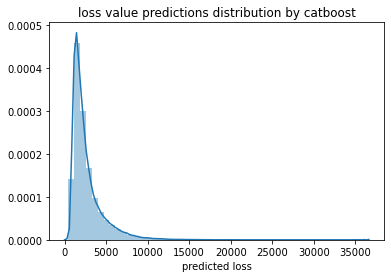

In [20]:
loss_submit('catboost', CatBoostRegressor(verbose=0),
            train_cat_df, target, test_cat_df)

### Models Tuning

Applying Grid search could easily lead to long processing time, hence extract 20% of the training data for tuning purposes.

In [21]:
sample_feature = feature.sample(frac=.2, random_state=10)
sample_target = target_t.loc[sample_feature.index.tolist()]

In [22]:
print(sample_feature.shape, sample_target.shape)

(37664, 112) (37664,)


In [23]:
# create empty dictionary to hold best parameters post tunning
sgd_tune = {}
lgb_tune = {}
xgb_tune = {}
cat_tune = {}

In [30]:
def fine_tune_model(dict_param, reg, params, s_train, s_test):
    clss = GridSearchCV(estimator=reg,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=2,
                        cv=2,
                        refit=False,
                        return_train_score=True)
    clss.fit(s_train, s_test)
    dict_param.update(clss.best_params_)

##### SGDRegression

In [31]:
sgd_params = {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
              'alpha': [.0001, .001, .01, .1],
              'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']}

In [32]:
fine_tune_model(sgd_tune, SGDRegressor(), sgd_params,
                sample_feature, sample_target)

sgd_tune

{'alpha': 0.001, 'learning_rate': 'adaptive', 'loss': 'epsilon_insensitive'}

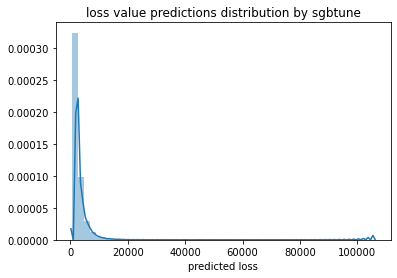

In [33]:
loss_submit('sgbtune', SGDRegressor(**sgd_tune), feature, target, final_test)

##### Lightgbm

In [34]:
lgbm_params = {'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [
    750, 1000, 1200], 'max_depth': [3, 6, 9]}

In [35]:
fine_tune_model(lgb_tune, LGBMRegressor(), lgbm_params,
                sample_feature, sample_target)

lgb_tune

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1200}

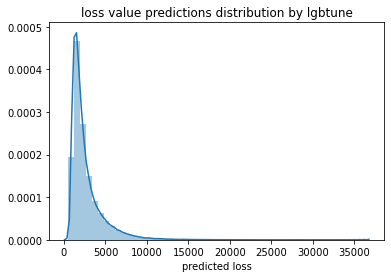

In [36]:
loss_submit('lgbtune', LGBMRegressor(**lgb_tune), feature, target, final_test)

##### Xgboost

In [37]:
xgb_params = {'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [100, 300, 500],
              'max_depth': [5, 8, 10]}

In [38]:
fine_tune_model(xgb_tune, XGBRegressor(objective='reg:squarederror'),
                xgb_params, sample_feature, sample_target)
xgb_tune

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

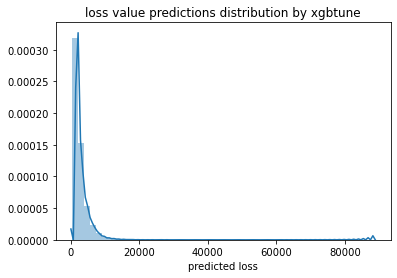

In [40]:
loss_submit('xgbtune', XGBRegressor(
    **xgb_tune, objective='reg:squarederror'), feature, target, final_test)

##### Catboost

Due to the long processing time, we apply the grid_search function within the Catboost package instead of using the defined function.

In [41]:
cat_params = {'depth': [6, 9, 12],
              'learning_rate': [0.1, 0.3, 0.5],
              'l2_leaf_reg': [1, 5, 10]}

In [42]:
model = CatBoostRegressor(verbose=0)

In [43]:
result = model.grid_search(cat_params, train_cat_df, y=target_t, train_size=.2,
                           verbose=True, refit=False, cv=2)

0:	loss: 0.6762680	best: 0.6762680 (0)	total: 14.7s	remaining: 6m 22s
1:	loss: 0.6805776	best: 0.6762680 (0)	total: 28.6s	remaining: 5m 57s
2:	loss: 0.6847022	best: 0.6762680 (0)	total: 46.3s	remaining: 6m 10s
3:	loss: 0.6753281	best: 0.6753281 (3)	total: 1m	remaining: 5m 48s
4:	loss: 0.6797223	best: 0.6753281 (3)	total: 1m 14s	remaining: 5m 28s
5:	loss: 0.6828131	best: 0.6753281 (3)	total: 1m 28s	remaining: 5m 9s
6:	loss: 0.6754134	best: 0.6753281 (3)	total: 1m 42s	remaining: 4m 52s
7:	loss: 0.6790338	best: 0.6753281 (3)	total: 1m 56s	remaining: 4m 35s
8:	loss: 0.6821229	best: 0.6753281 (3)	total: 2m 9s	remaining: 4m 19s
9:	loss: 0.6767792	best: 0.6753281 (3)	total: 2m 49s	remaining: 4m 48s
10:	loss: 0.6841614	best: 0.6753281 (3)	total: 3m 30s	remaining: 5m 6s
11:	loss: 0.6926752	best: 0.6753281 (3)	total: 4m 11s	remaining: 5m 14s
12:	loss: 0.6770576	best: 0.6753281 (3)	total: 4m 52s	remaining: 5m 15s
13:	loss: 0.6825738	best: 0.6753281 (3)	total: 5m 34s	remaining: 5m 10s
14:	loss: 0.

In [37]:
cat_tune = result['params']
cat_tune

{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

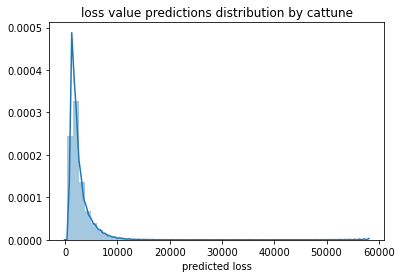

In [38]:
loss_submit('cattune', CatBoostRegressor(**cat_tune, iterations=1200, verbose=0),
            train_cat_df, target, test_cat_df)

| Model | MAE | Time |
| - | - | - |
|Dummy | 1783 | 1s |
|SGD Regression | 1267 | 1.6s |
|SGD Regression (tuned) | 1266 | 3.6s |
|Lightgbm (no tuning)| 1145 | 4s |
|Lightgbm (tuned) | 1129 | 12s |
|Xgboost (no tuning) | 1199 | 27s |
|Xgboost (tuned)| 1149 | 44s |
|Catboost (no tuning) | 1141 | 24s |
|Catboost (tuned)| 1122| 38s|